## Исследование текстовых данных для создания RAG-сервиса

В рамках разработки Retrieval-Augmented Generation (RAG)-сервиса, эффективная предобработка текстовых данных играет ключевую роль в обеспечении высокой точности и релевантности результатов поиска. Данное исследование направлено на анализ предоставленного набора текстовых документов с целью выявления потенциальных проблем с качеством данных и определения статистических характеристик текстов. Результаты этого исследования послужат основой для разработки стратегии предобработки, оптимизированной для RAG-сервиса.

[Добавьте ссылку](#download)


Задачи:
1. выявление проблем с качеством данных
2. определение статистических показателей текстов

### Библиотеки

In [2]:
import requests
import matplotlib.pyplot as plt
from typing import List, Dict, Any
import unicodedata
import numpy as np
import re
from collections import Counter
from langchain.text_splitter import RecursiveCharacterTextSplitter

### Используемые функции

In [3]:
def check_quality(data: List[Dict[str, Any]]) -> List[str]:
    """
    Проверяет качество текстовых данных в списке словарей, выявляя символы управления,
    символы с неизвестным именем и символы из категорий 'Cc', 'Cf', 'Cs', 'Co', 'Cn'
    (в соответствии с классификацией Unicode).

    Аргументы:
        data: Список словарей, где каждый словарь содержит текстовые данные.
        text_key: Ключ, по которому в словаре хранится текстовая строка для проверки.
                  По умолчанию используется ключ "text".

    Возвращает:
        Список подозрительных символов, найденных во всех текстах. Если подозрительные
        символы не найдены, возвращается пустой список.
    """
    all_bad_chars = []
    for item in data:
        text = item.get("text")
        bad_chars = []
        for char in text:
            try:
                name = unicodedata.name(char)
                category = unicodedata.category(char)
                if category in ('Cc', 'Cf', 'Cs', 'Co', 'Cn'):
                    bad_chars.append(char)
            except ValueError:
                bad_chars.append(char)
        all_bad_chars.extend(bad_chars)
    return set(all_bad_chars)

In [4]:
def data_analys(data: List[Dict[str, Any]]) -> None:
    """
    Выполняет анализ набора текстовых документов и предоставляет статистическую информацию
    о длине документов, а также визуализирует распределение длин документов с помощью
    гистограммы и ящика с усами.

    Args
        data: Список словарей, где каждый словарь представляет собой документ и содержит ключ "text",
              значением которого является строка с текстом документа.

    Returns:
        Функция выводит на экран:
            - Количество документов в наборе.
            - Общий объем текста (в символах) во всех документах.
            - Среднюю, минимальную и максимальную длину документа (в символах).
        Также функция отображает:
            - Гистограмму распределения длин документов.
            - Ящик с усами (boxplot) для представления разброса длин документов.
    """
    print("\nАнализ данных:")
    doc_lengths = [len(doc["text"]) for doc in data]
    print(f"Количество документов: {len(data)}")
    print(f"Общий объем текста: {sum(len(doc["text"]) for doc in data)} символов")
    print(f"Средняя длина документа: {np.mean(doc_lengths):.2f} символов")
    print(f"Минимальная длина документа: {min(doc_lengths)} символов")
    print(f"Максимальная длина документа: {max(doc_lengths)} символов")

    fig, ax = plt.subplots(2, 1, figsize=(10,13))
    ax[0].hist(doc_lengths, bins=50)
    ax[0].set_xlabel("Длина документа (символы)")
    ax[0].set_ylabel("Количество документов")
    ax[0].set_title("Распределение длин документов")
    ax[1].boxplot(doc_lengths, vert=False)
    ax[1].set_xlabel("Длина документа (символы)")
    ax[1].set_ylabel("")
    ax[1].set_title("Ящик с усами")
    ax[0].grid()
    ax[1].grid()
    plt.show()

In [5]:
def clean_text(data: List[Dict[str, Any]]) -> List[Dict]:
    """
    Очищает текст непосредственно в словарях списка data от символов управления и символов с неизвестным именем.
    Args:
        data: Список словарей, где каждый словарь имеет ключ "text".
    Returns:
        Список словарей с очищенным текстом (измененный исходный список).
    """
    total_bad_char_count = 0
    for item in data:
        text = item["text"]
        cleaned_text = ""
        bad_char_count = 0
        for char in text:
            try:
                if unicodedata.category(char) in ('Cc', 'Cf', 'Cs', 'Co', 'Cn'):
                    bad_char_count += 1
                    continue
                else:
                    cleaned_text += char
            except ValueError:
                bad_char_count += 1
                continue
        item["text"] = cleaned_text
        total_bad_char_count += bad_char_count
    print(f"Всего удалено подозрительных символов: {total_bad_char_count}")
    return data

In [6]:
def tokenize(text: str) -> List[str]:
    """Разбивает текст на слова, удаляя знаки препинания и приводя к нижнему регистру."""
    text = re.sub(r'[^\w\s]', '', text)
    return text.lower().split()


def check_vocab(data: List, word_number: int) -> None:
    """
    Анализирует словарный состав (vocab) набора текстовых документов и выводит
    статистику о частоте употребления слов, в частности, топ наиболее частых слов.

    Args:
        data: Список словарей, где каждый словарь представляет собой документ и содержит ключ "text",
              значением которого является строка с текстом документа.
        word_number: Целое число, определяющее количество самых частых слов, которые нужно вывести на экран.

    Returns:
        Функция выводит на экран:
            - Общее количество уникальных слов в наборе документов.
            - Список топ `word_number` самых частых слов, отсортированных по убыванию частоты,
              с указанием частоты употребления каждого слова.
    """
    all_words = []
    for doc in data:
        all_words.extend(tokenize(doc["text"]))

    word_counts = Counter(all_words)
    print(f"Всего уникальных слов: {len(word_counts)}")
    print(f"Топ-{word_number} самых частых слов:")
    for word, count in word_counts.most_common(word_number):
        print(f"  {word}: {count:,}")

### Загрузка данных <a id="download"></a>

In [ ]:
# url = УКАЖИТЕ ССЫЛКУ
response = requests.get(url, timeout=10)
response.raise_for_status()
data = response.json()
data[0]

{'uid': 0,
 'ru_wiki_pageid': 58311,
 'text': 'ЦСКА — советский и российский профессиональный хоккейный клуб из Москвы, выступающий в Континентальной хоккейной лиге. Основан в 1946 году под названием ЦДКА (Центральный дом Красной Армии). В 1951 году переименован в ЦДСА (Центральный дом Советской Армии), а в 1954 в ЦСК МО (Центральный спортивный клуб Министерства обороны), под которым выступал до 1959 года, и с тех пор носит название ЦСКА (Центральный Спортивный Клуб Армии).'}

В данных присутствует единая структура:
* uid - уникальный номер абзаца
* ru_wiki_pageid - id страницы в Википедии
* text - текст абзаца

In [8]:
print(f"Обнаруженные в текстах символы: {check_quality(data)}")

Обнаруженные в текстах символы: {'\u06dd', '\u200e', '\u200f', '\ufeff', '\u200b', '\u200d', '\xad', '\t', '\u200c'}


In [9]:
clean_data = clean_text(data)
print(f"Обнаруженные в текстах символы: {check_quality(clean_data)}")

Всего удалено подозрительных символов: 972
Обнаруженные в текстах символы: set()


In [10]:
for text in clean_data:
    text["text"] = unicodedata.normalize('NFC', text["text"])

Данные очищены от подозрительных и ненужных символов.

### Анализ данных

Выполним анализ количества текстов, длин абзацев.


Анализ данных:
Количество документов: 56952
Общий объем текста: 25542946 символов
Средняя длина документа: 448.50 символов
Минимальная длина документа: 1 символов
Максимальная длина документа: 11010 символов


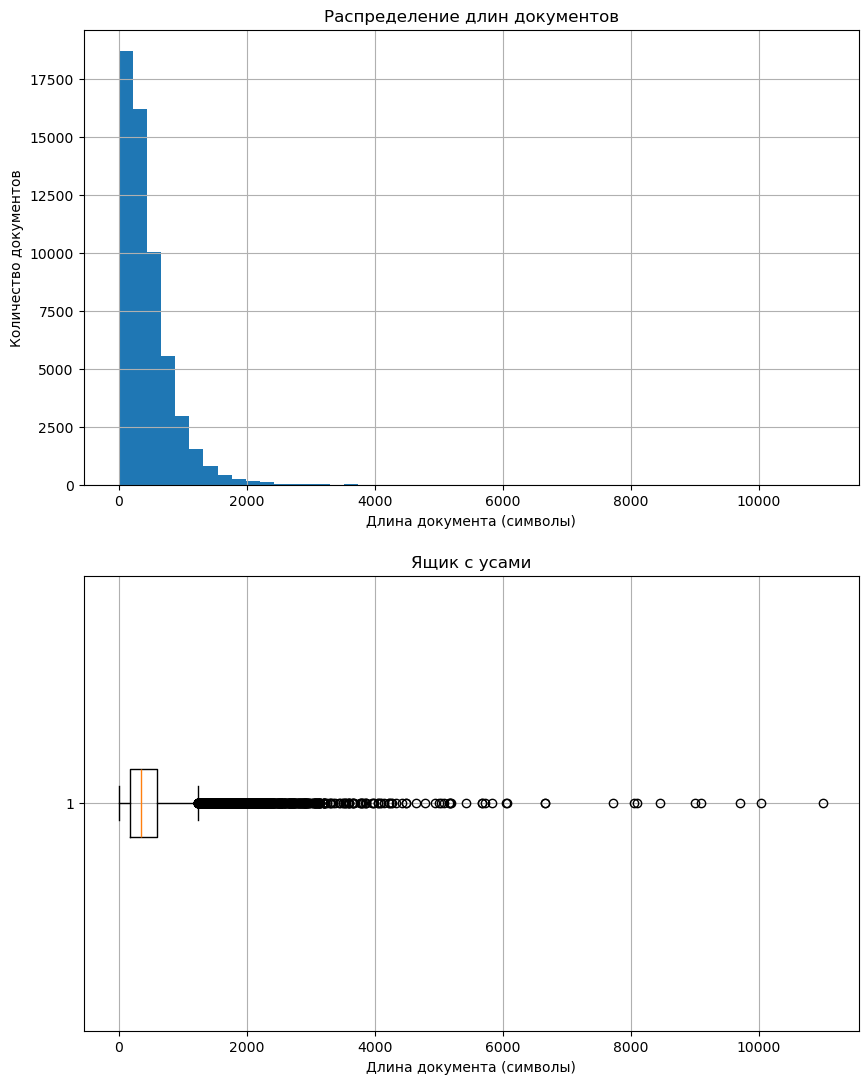

In [11]:
data_analys(data)

Встречается ряд практически пустых текстов. Общая статистика показывает следующее:
* Количество документов: 56952
* Общий объем текста: 25542946 символов
* Средняя длина документа: 448.50 символов
* Минимальная длина документа: 1 символов
* Максимальная длина документа: 11010 символов

Оценим длины текстов целиком (конкатенированных по ru_wiki_pageid)

In [12]:
wiki_pages_id = set([doc["ru_wiki_pageid"] for doc in data])
len(wiki_pages_id)

9105

В данных 9105 статей. Оценим распределение длин статей.

In [13]:
wiki_pages = []
i = 0
for doc in data:
    if doc["ru_wiki_pageid"] != wiki_pages[i][]"ru_wiki_pageid":
        wiki_pages[i][] = [doc["text"]]
        i += 1
    else:
        wiki_pages[i][doc["ru_wiki_pageid"]].append(doc["text"])

for i in range(len(wiki_pages)):
    for key, pages in wiki_pages[i].items():
        wiki_pages["text"] = " ".join(pages)

In [26]:
grouped_articles = {}
for doc in data:
    page_id = doc["ru_wiki_pageid"]
    text = doc["text"].strip()
    if page_id in grouped_articles:
        grouped_articles[page_id].append(text)
    else:
        grouped_articles[page_id] = [text]
wiki_pages = []
for page_id, texts in grouped_articles.items():
    combined_text = " ".join(texts).strip()
    wiki_pages.append({"ru_wiki_pageid": page_id, "text": combined_text})


Анализ данных:
Количество документов: 9105
Общий объем текста: 25590793 символов
Средняя длина документа: 2810.63 символов
Минимальная длина документа: 30 символов
Максимальная длина документа: 102582 символов


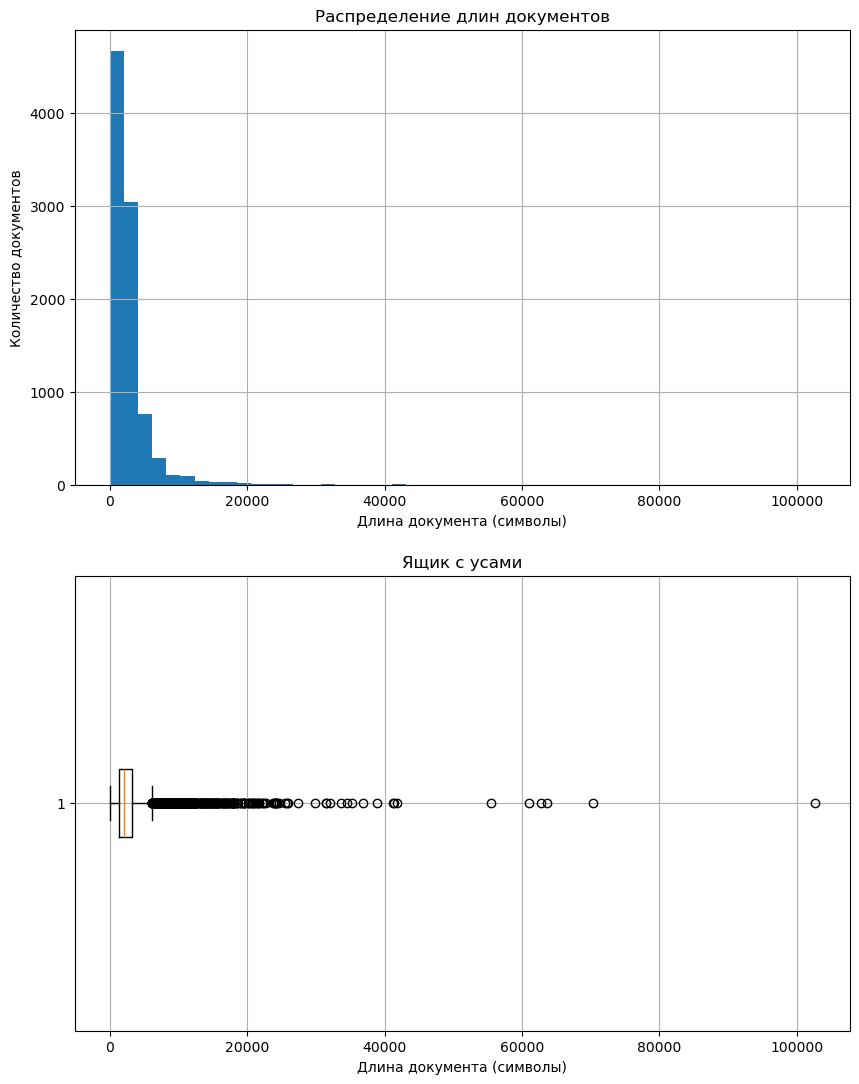

In [27]:
data_analys(result)

На гистограмме мы наблюдаем некоторое количество выбросов - отрывков, размером более 5000 символов. Оценим количество коротких строк.

In [15]:
for key, page in wiki_pages.items():
    if len(page) < 50:
        print(f"id_page: {key}, page: {page}")

id_page: 850522, page: Знахарь — «народный» целитель, ведун.
id_page: 710426, page: Крупнейшие озёра и закрытые лиманы Украины.
id_page: 1259871, page: Это список национальных парков Болгарии.
id_page: 672406, page: Впервые замужем (рассказ) — рассказ Павла Нилина
id_page: 6128214, page: Русские названия даны в переводе Cartoon Network.
id_page: 1101222, page: Королевство Саудовская Аравия.
id_page: 2955348, page: Карл у Клары украл Кораллы (ст. Д. Джокер)
id_page: 325747, page: Человек-амфибия (фильм, 2005).


Таким образом, мы видим, что имеются совсем небольшие статьи (до 50 знаков). Причин возникновения таких страниц может быть много, и они связаны с ошибкой выгрузки. Однако, мы избавились от абсолютно пустых страниц. А значит, теперь можем разбить данные на чанки без опасения получить неизвестные токены.

### Разделение текста на чанки и анализ результатов

In [16]:
splitter = RecursiveCharacterTextSplitter(chunk_size=512, chunk_overlap=100)
final_chunks = []
i = 0
for key, page in wiki_pages.items():
    for text in splitter.split_text(page):
        final_chunks.append({
            "uid": i,
            "ru_wiki_pageid": key,
            "text": text,
        })
        i += 1

In [17]:
print(final_chunks[:1])

[{'uid': 0, 'ru_wiki_pageid': 58311, 'text': 'ЦСКА — советский и российский профессиональный хоккейный клуб из Москвы, выступающий в Континентальной хоккейной лиге. Основан в 1946 году под названием ЦДКА (Центральный дом Красной Армии). В 1951 году переименован в ЦДСА (Центральный дом Советской Армии), а в 1954 в ЦСК МО (Центральный спортивный клуб Министерства обороны), под которым выступал до 1959 года, и с тех пор носит название ЦСКА (Центральный Спортивный Клуб Армии). В первом сезоне в составе Континентальной хоккейной лиги ЦСКА выиграл дивизион'}]



Анализ данных:
Количество документов: 64493
Общий объем текста: 30848105 символов
Средняя длина документа: 478.32 символов
Минимальная длина документа: 30 символов
Максимальная длина документа: 512 символов


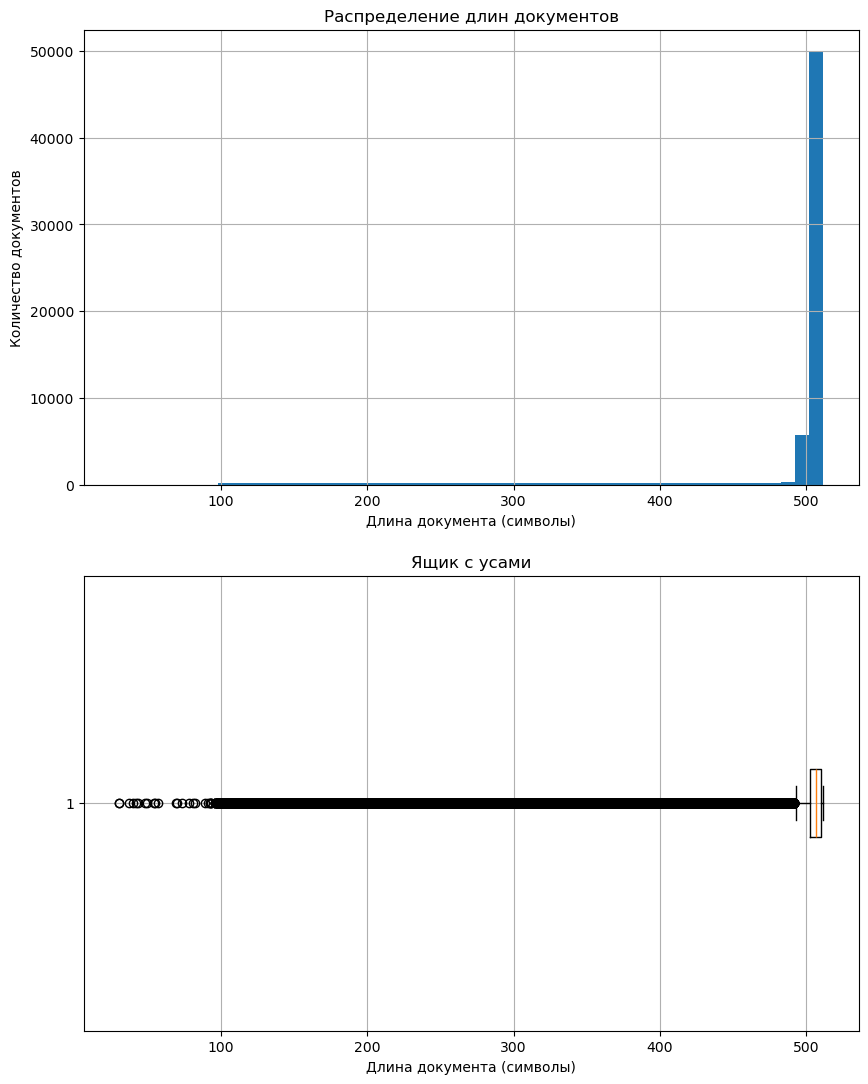

In [18]:
data_analys(final_chunks)

После чанкизации мы получили отрывки, размером не превышающие 512 знаков. Кроме того, чанк имеет перекрытие с соседним чанком на 100 символов, чтобы не потерять контекст.

### Анализ словаря текстов

Этот анализ необходим, чтобы составить словарь нерелевантных слов и улучшить поиск по векторной базе данных.

In [19]:
check_vocab(final_chunks, 20)

Всего уникальных слов: 314304
Топ-20 самых частых слов:
  в: 204,706
  и: 136,221
  на: 67,032
  с: 51,191
  года: 29,532
  по: 29,429
  не: 24,135
  из: 22,895
  что: 22,322
  году: 21,401
  к: 21,100
  а: 20,577
  его: 16,693
  был: 16,328
  как: 16,253
  от: 16,157
  для: 15,589
  он: 12,717
  за: 12,478
  о: 12,298


Мы видим, что наиболее часто используемые слова - это союзы и предлоги. Однако, это не является причиной для их удаления. Мы пременяем embeddings - векторизированный текст с учетом контекста, поэтому удаление предлогов можешь привести к потере содержания. Однако, если бы мы применяли Word2Vec модели, предлоги желательно было бы удалить.